In [178]:
# Import matplotlib
%matplotlib notebook
#from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [179]:
#Import numpy and pandas 
import numpy as np
import pandas as pd

In [180]:
#Import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [181]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [182]:
# Creat engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [183]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [184]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [185]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [186]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


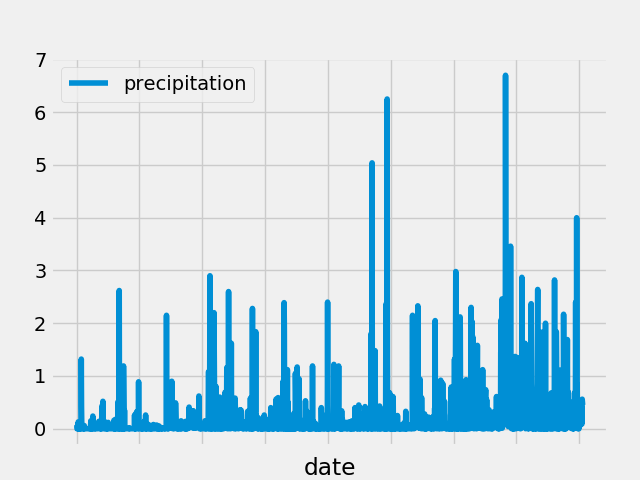

In [189]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
# Perform a query to retrieve the data and precipitation scores
year_prcp = pd.read_sql("select date, prcp as precipitation from measurement where date > (select date((select max(date) from measurement),'-365 day'))", engine)
# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date
year_prcp.set_index('date', inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
year_prcp.dropna().plot()
plt.tight_layout
# Rotate the xticks for the dates
plt.xticks(x='date', rotation='vertical')
plt.show()
plt.savefig("twelve_month_precipitation.png")

In [191]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [192]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [193]:
# What are the most active stations?
most_active_stations = session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.prcp).desc())
# List the stations and the counts in descending order.
for station in most_active_stations:
    print(station)

most_active = most_active_stations[0][0]   


('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [194]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_range = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active).order_by(Measurement.date).all()
# print temparature range for most active station
temperature_range

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


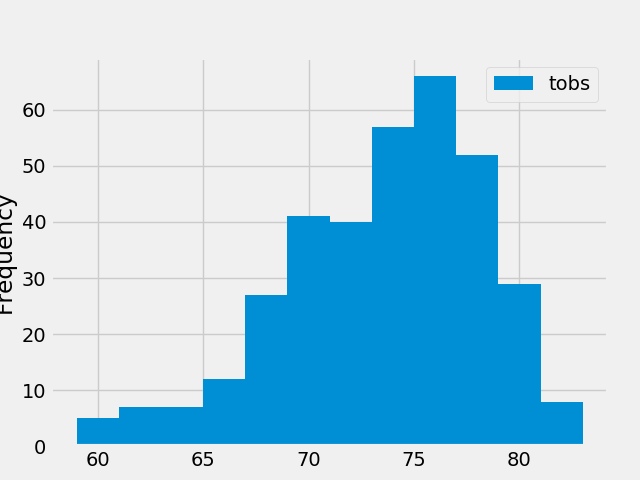

In [195]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > (dt.date(2017, 8, 23) - dt.timedelta(days=365))).\
    order_by(Measurement.date).all()

# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)

temp_df.plot.hist(bins=12)
plt.show()
plt.savefig("twelve_month_StationAnalysis.png")

In [196]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
   
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    calcs = session.query(*sel).filter(func.strftime('%Y-%m-%d', Measurement.date)\
            .between(start_date, end_date)).one()
    return calcs
#print(calc_temps('2012-02-28', '2012-03-05'))

In [197]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


(71.0, 77.78947368421052, 82.0)


<IPython.core.display.Javascript object>


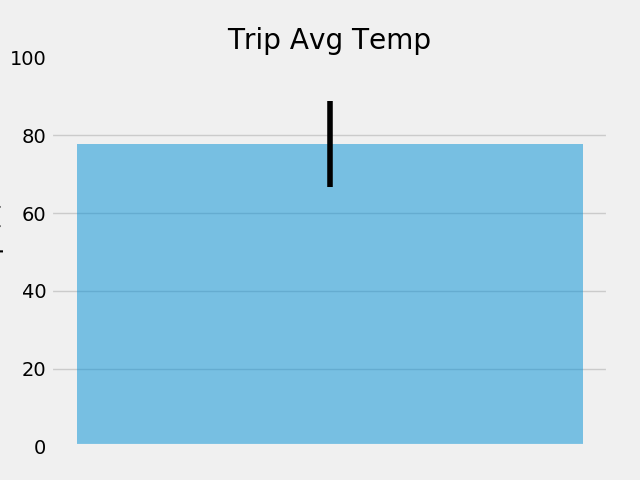

In [198]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_arrive = dt.date(2018, 10, 1)
trip_leave = dt.date(2018, 10, 15)
# used the data two years ago as there wasn't date for the last year.
last_year = dt.timedelta(days=730)
trip_temps_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(trip_temps_lst_year)

trip_avg = trip_temps_lst_year[1]
trip_max = trip_temps_lst_year[2]
trip_min = trip_temps_lst_year[0]


plt.figure() 
plt.bar(1,trip_avg, yerr=(trip_max-trip_min), width=0.0001, alpha=0.5)
plt.xticks([])

plt.ylim(0,100)
plt.title("Trip Avg Temp")
plt.ylabel('Temp (F)')
plt.tight_layout

plt.savefig("trip_temperature_analysis.png")
plt.show()

In [220]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_per_station = session.query((Station.station), func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation)\
            .filter(Station.station == Measurement.station)\
            .filter(Measurement.date.between('2016-10-01','2016-10-15')).group_by(Measurement.station)\
            .order_by(func.sum(Measurement.prcp).desc()).all()
prcp_per_station


[('USC00516128',
  7.209999999999998,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  0.7500000000000001,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  0.30000000000000004,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00514830',
  0.22,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 0.07, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519523',
  0.07,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


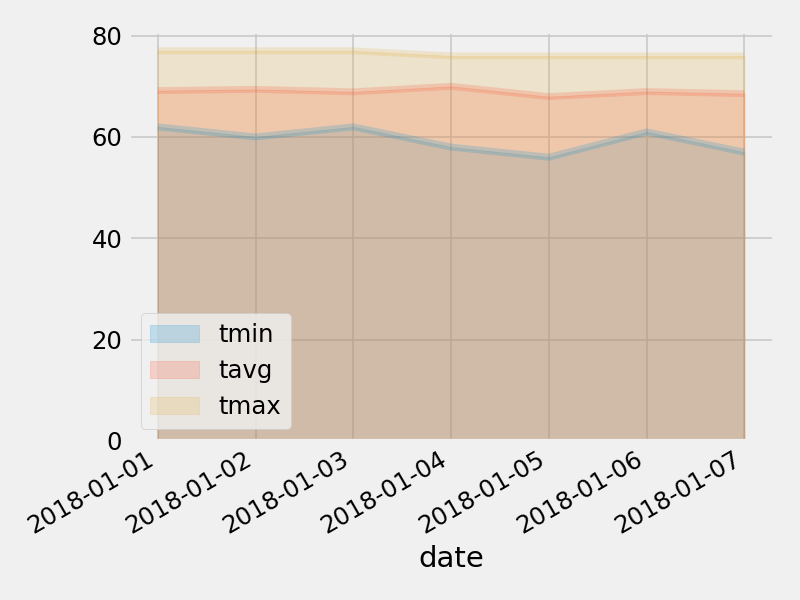

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
